# Attributing promotion to sales

In [1]:
# Importing the required Library

%pylab inline
import pandas as pd
plt.style.use('ggplot')
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


## Uploading the dataset

![title](abalone.jpg) 

In [2]:
pip install smart_open

     |████████████████████████████████| 71kB 30.5MB/s eta 0:00:01
     |████████████████████████████████| 133kB 50.3MB/s eta 0:00:01
     |████████████████████████████████| 71kB 40.4MB/s eta 0:00:01
     |████████████████████████████████| 6.0MB 55.9MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=73088 sha256=d499228a5cc5717dfefe907dd959fdfbb603dc7b1f2a379e3ff938426efe8af0
  Stored in directory: /home/ubuntu/.cache/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from smart_open import smart_open
aws_key = '*****************'
aws_secret = '****************'

bucket_name = 'abhiclass'
object_key = 'pcb_dataset_final.tsv'

path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key)

df = pd.read_csv(smart_open(path), sep='\t')
df0=df

/home/ubuntu/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
# DATA_FILE='pcb_dataset_final.tsv'
# df = pd.read_csv(DATA_FILE, sep='\t')
# df0=df

# use this read from Compressed file
# DATA_FILE='criteo_attribution_dataset.tsv.gz'
# df = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

In [5]:
# Converting time into Days

df['day'] = np.floor(df.timestamp / 86400.).astype(int)

In [6]:
d = df.groupby(['uid']).count()


In [7]:
df_converted_test = df[df['conversion'] == 1]

In [8]:
df_converted_test[df_converted_test['uid'] == 15040155]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day
5981398,939280,15040155,16184517,1,939298,3656937,1,1,0,1,...,27093701,26597095,7711526,29196072,3225250,5824238,22909613,29196072,29196072,10
11507489,1845813,15040155,26891650,1,3866007,20923628,0,1,0,1,...,25259032,32440046,1223615,29196072,26611395,28928366,26270263,29196072,29196072,21


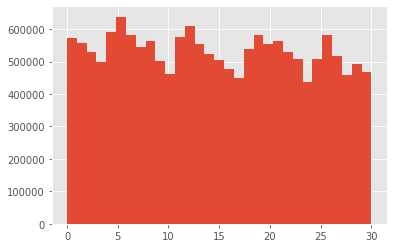

In [9]:
df.day.hist(bins=len(df.day.unique()))

In [10]:
df['gap_click_sale'] = -1
df.loc[df.conversion == 1, 'gap_click_sale'] = df.conversion_timestamp - df.timestamp

In [11]:
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 
            'cat7', 'cat8']
INFOS = ['cost', 'cpo', 'time_since_last_click']

In [12]:
def add_derived_columns(df):                               # step 1: add JID and standartize timestamps 
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [13]:
def sample_campaigns(df, n_campaigns):                     # step 2.1: reduce the dataset by sampling campaigns
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def filter_journeys_by_length(df, min_touchpoints):        # step 2.2: remove short (trivial) journeys
    grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
    return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [14]:
def balance_conversions(df):                               # step 3: balance the dataset: 
    df_minority = df[df.conversion == 1]                   # The number of converted and non-converted events should be equal.
    df_majority = df[df.conversion == 0]                   # We take all converted journeys and iteratively add non-converted 
                                                           # samples until the datset is balanced. We do it this way becasue  
    df_majority_jids = np.array_split(                     # we are trying to balance the number of events, but can add only
          df_majority['jid'].unique(),                     # the whole journeys.
          100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([
            df_majority_sampled, 
            df_majority[df_majority.jid.isin(jid_chunk)]
        ])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [15]:
def map_one_hot(df, column_names, result_column_name):      # step 4: one-hot encoding for categorical variables
    mapper = {}                                             # We use custom mapping becasue IDs in the orginal dataset
    for i, col_name in enumerate(column_names):             # are not sequential, and standard one-not encoding 
        for val in df[col_name].unique():                   # provided by Keras does not handle this properly.
            mapper[val*10 + i] = len(mapper)
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            mapped_val_id = mapper[val*10 + i]
            v[mapped_val_id] = 1
        return v    
    
    df_ext = df.copy()
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
n_campaigns = 400

In [16]:
df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
# all categories are mapped to one vector  
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
# the final dataframe used for modeling  
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])    

In [17]:
print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

565908
[284210, 281698]


In [18]:
df6[df6['uid'] == 6013772]['day'].max()

13

In [19]:
df6.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'day', 'gap_click_sale', 'jid',
       'timestamp_norm', 'time_since_last_click_norm', 'cats', 'campaigns'],
      dtype='object')

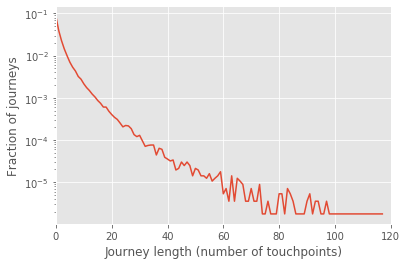

In [20]:
# Data exploration
def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

plt.plot(range(len(hist_y)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## Last-Touch Attribution

![title](image/lta.png) 

In [21]:
# function for last touch attribution
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)


## First Touch Attribution

![title](image/fta.png) 

In [22]:

def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

## U-shaped attribution

![title](image/usa.png) 

In [23]:
def position_based_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    a =2
    df_converted = df[df['conversion'] == 1]
    idx2 = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    idx1 = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    count_idx2 = count_by_campaign(df_converted[idx2])
    count_idx1 = count_by_campaign(df_converted[idx1])
    campaign_conversions =0.35* count_idx2 + 0.35*count_idx1 + 0.3*(count_by_campaign(df_converted) - count_idx2 - count_idx1)
        
    return campaign_conversions / campaign_impressions
    
pba = position_based_attribution(df6)

## Linear Touch Attribution

![title](image/linear.png) 

In [24]:
def linear_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
lita = linear_touch_attribution(df6)

In [25]:
df6_max_day_dict = {}

## Time Decay touch attribution

![title](image/tda.png) 

In [26]:
for uid in df_converted_test['uid'].unique():
    df6_max_day_dict[uid] = df_converted_test[df_converted_test['uid'] == uid]['day'].max()

In [27]:
def time_decay_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    def count_by_timedecay_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot, day, uid in zip(df['campaigns'].values, df['day'].values, df['uid'].values):
            campaign_id = np.argmax(campaign_one_hot)
            time_decay_coefficient = 2**(-(df6_max_day_dict[uid] - day)/7)
            counters[campaign_id] = counters[campaign_id] + time_decay_coefficient
        return counters
    
    df_converted = df[df['conversion'] == 1]
    campaign_conversions = count_by_timedecay_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
tdta = time_decay_touch_attribution(df6)

In [28]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [29]:

x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(118792, 1564)


In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [31]:

# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8678816448503724


In [32]:
pip install tensorflow

     |████████████████████████████████| 421.8MB 246kB/s  eta 0:00:01
     |████████████████████████████████| 26.1MB 44.8MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 46.7MB/s eta 0:00:01
     |████████████████████████████████| 112kB 54.9MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 54.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 31.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 33.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 30.7MB/s eta 0:00:01
     |████████████████████████████████| 2.7MB 45.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 33.1MB/s eta 0:00:01
     |████████████████████████████████| 450kB 58.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 35.3MB/s eta 0:00:01
     |████████████████████████████████| 92kB 46.2MB/s eta 0:00:01
     |████████████████████████████████| 163kB 59.5MB/s eta 0:00:01
     |████████████████████████████████| 81kB 37.6MB/s eta 0:00:01

In [33]:
pip install keras

     |████████████████████████████████| 378kB 10.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Using TensorFlow backend.


Train on 76026 samples, validate on 19007 samples
Epoch 1/10
76026/76026 [==============================] - 2s 31us/step - loss: 0.5281 - accuracy: 0.7707 - val_loss: 0.4772 - val_accuracy: 0.7973
Epoch 2/10
76026/76026 [==============================] - 2s 25us/step - loss: 0.4508 - accuracy: 0.8127 - val_loss: 0.4439 - val_accuracy: 0.8157
Epoch 3/10
76026/76026 [==============================] - 2s 20us/step - loss: 0.4255 - accuracy: 0.8238 - val_loss: 0.4262 - val_accuracy: 0.8235
Epoch 4/10
76026/76026 [==============================] - 1s 19us/step - loss: 0.4105 - accuracy: 0.8314 - val_loss: 0.4149 - val_accuracy: 0.8295
Epoch 5/10
76026/76026 [==============================] - 1s 19us/step - loss: 0.4002 - accuracy: 0.8364 - val_loss: 0.4070 - val_accuracy: 0.8337
Epoch 6/10
76026/76026 [==============================] - 2s 24us/step - loss: 0.3926 - accuracy: 0.8403 - val_loss: 0.4005 - val_accuracy: 0.8355
Epoch 7/10
76026/76026 [==============================] - 2s 23us/st

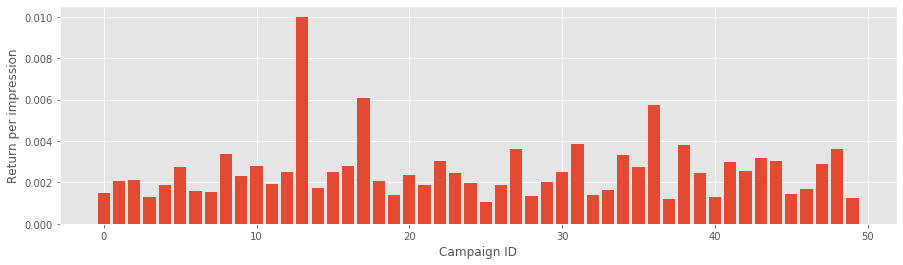

In [35]:
campaign_idx = range(150, 200)

# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

## LSTM

In [36]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])
    
    x3d = []
    y = []
    for xi in x3d_list:
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi)
        journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        n_touchpoints = len(journey_matrix)
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y

x, y = features_for_lstm(df6, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

(118792, 15, 1566)


In [37]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 76026 samples, validate on 19007 samples
Epoch 1/5
76026/76026 [==============================] - 41s 538us/step - loss: 0.3231 - accuracy: 0.8559 - val_loss: 0.2674 - val_accuracy: 0.8838
Epoch 2/5
76026/76026 [==============================] - 40s 523us/step - loss: 0.3027 - accuracy: 0.8657 - val_loss: 0.2610 - val_accuracy: 0.8859
Epoch 3/5
76026/76026 [==============================] - 38s 502us/step - loss: 0.2969 - accuracy: 0.8686 - val_loss: 0.2608 - val_accuracy: 0.8864
Epoch 4/5
76026/76026 [==============================] - 38s 504us/step - loss: 0.2926 - accuracy: 0.8695 - val_loss: 0.2583 - val_accuracy: 0.8870
Epoch 5/5
76026/76026 [==============================] - 38s 504us/step - loss: 0.2889 - accuracy: 0.8722 - val_loss: 0.2569 - val_accuracy: 0.8881
Test score: 0.24908154771366003
Test accuracy: 0.8905256986618042


In [38]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

main_output = Dense(1, activation='sigmoid')(weighted_activations)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 76026 samples, validate on 19007 samples
Epoch 1/5
76026/76026 [==============================] - 42s 554us/step - loss: 0.2358 - accuracy: 0.9000 - val_loss: 0.2158 - val_accuracy: 0.9086
Epoch 2/5
76026/76026 [==============================] - 40s 529us/step - loss: 0.2086 - accuracy: 0.9123 - val_loss: 0.2051 - val_accuracy: 0.9131
Epoch 3/5
76026/76026 [==============================] - 40s 527us/step - loss: 0.1961 - accuracy: 0.9178 - val_loss: 0.2019 - val_accuracy: 0.9169
Epoch 4/5
76026/76026 [==============================] - 40s 526us/step - loss: 0.1916 - accuracy: 0.9201 - val_loss: 0.1991 - val_accuracy: 0.9168
Epoch 5/5
76026/76026 [==============================] - 40s 521us/step - loss: 0.1883 - accuracy: 0.9217 - val_loss: 0.1974 - val_accuracy: 0.9170
Test score: 0.1865552863642919
Test accuracy: 0.9220085144042969


In [39]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

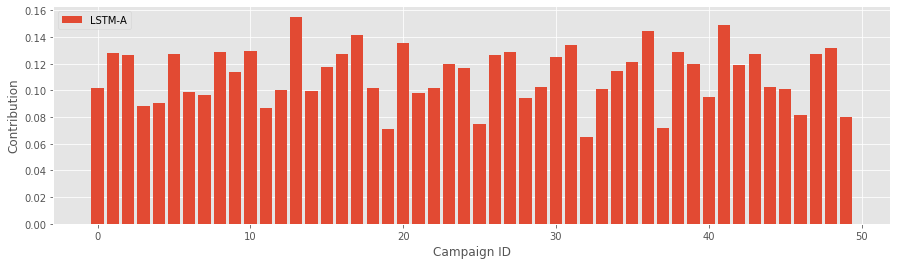

In [40]:
lstm_a = (attributions/campaign_freq)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

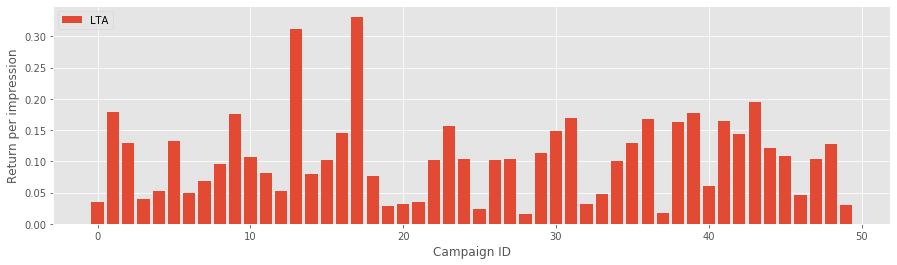

In [43]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [44]:
from matplotlib.pylab import plt


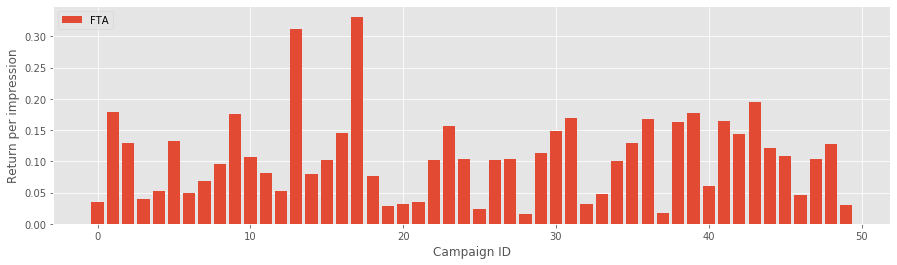

In [46]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

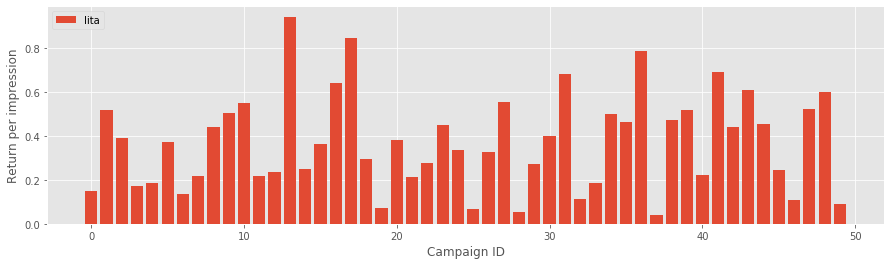

In [47]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lita[campaign_idx])), lita[campaign_idx], label='lita' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

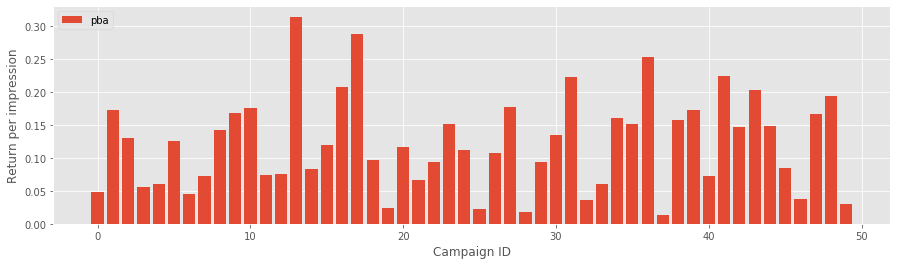

In [48]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(pba[campaign_idx])), pba[campaign_idx], label='pba' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

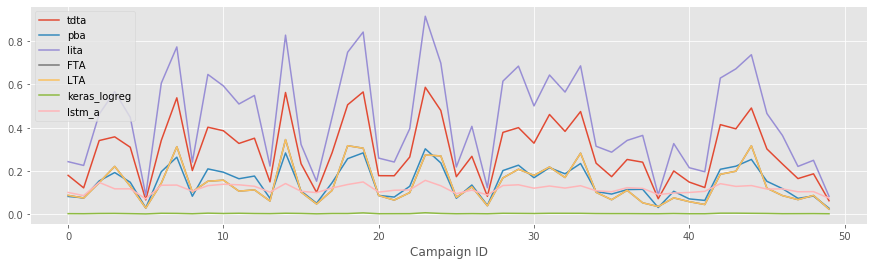

In [52]:
campaign_idx = range(100, 150)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.plot( range(len(tdta[campaign_idx])), tdta[campaign_idx], label='tdta' )
plt.plot( range(len(pba[campaign_idx])), pba[campaign_idx], label='pba' )
plt.plot( range(len(lita[campaign_idx])), lita[campaign_idx], label='lita' )
plt.plot( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.plot( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.plot( range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx], label='keras_logreg' )
plt.plot( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='lstm_a' )
plt.xlabel('Campaign ID')

plt.legend(loc='upper left')
plt.show()

In [53]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [54]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose): 
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [ ]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, fta, pba,tdta,lita,keras_logreg, lstm_a]
attr_name = ["lta", "fta", "pba", "tdta", "lita","keras_logreg", "lstm_a"]
budget_roi = pd.DataFrame(columns=["pitch", "lta", "pba", "lita", "tdta", "fta","keras_logreg", "lstm_a"], index=np.arange(len(pitches)))
for i, pitch in enumerate(pitches):
    budget_roi["pitch"].loc[i] = pitch
    for j, (attribution, attr_n) in enumerate(zip(attributions, attr_name)):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        budget_roi[attr_n].loc[i] = reward
        print('{} {} : {}'.format(i, j, reward))

0 0 : 1324
0 1 : 1324
0 2 : 1370
0 3 : 1372
0 4 : 1388
0 5 : 1074
0 6 : 1156
1 0 : 1151
1 1 : 1151


In [ ]:
import param
class Gapminder(param.Parameterized):
    pitch = param.ObjectSelector(objects=list(budget_roi.pitch.unique()),default=0.1)
    show_legend = param.Boolean(default=True)

    ylim = (0.0, 2000,250)
    xlim = (0.0, 3.0,0.25) 


    def get_data(self):
        df = budget_roi[(budget_roi.pitch==self.pitch)].copy()
        return df
    
    def get_clusters(self):
        print(x)
        data  = self.get_data()
        print(data)
        plot  = data.hvplot.bar('pitch',
                  logx=True, width=700, height=350, legend=self.show_legend)

        return (plot)
    
gm = Gapminder(name='')

pn.Column(gm.param,
          pn.Row(gm.get_clusters))

In [ ]:
df = budget_roi

In [ ]:
from io import StringIO # python3; python2: BytesIO 
import boto3

bucket = 'abhiadm' # already created on S3
csv_buffer = StringIO()
df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3', aws_access_key_id='xxxxxxxxxxxx', aws_secret_access_key='xxxxxxxxxxxxx')
s3_resource.Object(bucket, 'df.csv').put(Body=csv_buffer.getvalue())